In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd

In [4]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Load model

### User Input:
1. model_path - path to .pickle file of pretrained model
2. train_data_path - path to train data
3. test_data_path - path to test data
4. categorical_features - which features are categorical

In [5]:
model_path = 'loan_model.pickle'
train_data_path = 'loan_model_train_data.csv'
test_data_path = 'loan_model_test_data.csv'
categorical_features = [0, 1, 2, 3, 4, 9, 10, 11]

---

In [6]:
import pickle
pickle_in = open(model_path,"rb")
model = pickle.load(pickle_in)
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [7]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [12]:
def model_prediction(x):
    return model.predict_proba(x)

# Skater (analyze model)

## Feature importance

[12/12] features ████████████████████ Time elapsed: 0 seconds

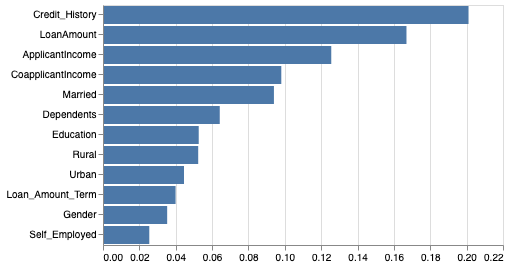

In [9]:
from src import feature_importance
feature_importance.analyze(model_prediction, train_data, render=True)

## Partial dependence 


[400/400] grid cells ████████████████████ Time elapsed: 1 seconds

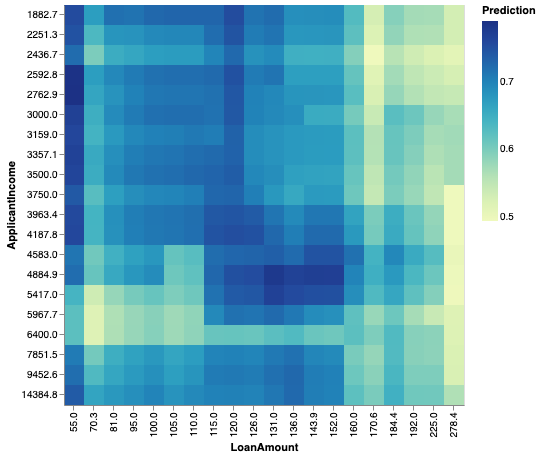

In [35]:
from src import partial_dependence

feature_1 = 'LoanAmount'
feature_2 = 'ApplicantIncome'

partial_dependence.analyze([feature_1, feature_2], model_prediction, train_data, render=True)

### TreeSurrogates (Experimental)

In [13]:
# help(interpreter.tree_surrogate)

## Contrastive explanation
Based on https://arxiv.org/pdf/1806.07470.pdf and https://github.com/MarcelRobeer/ContrastiveExplanation

In [8]:
# from IPython.core.debugger import set_trace
import src.contrastive_explanation as ce
dm = ce.domain_mappers.DomainMapperTabular(train_data.values, 
                                           feature_names = train_data.columns,
                                           categorical_features = categorical_features)

exp = ce.ContrastiveExplanation(dm)

### User Input:

- select test data indexes

In [9]:
indexes = [3,6]

---

In [10]:
for i in indexes:
    sample = test_data.values[i]
    print('------')
    print(sample)
    print(exp.explain_instance_domain(model_prediction, sample))

------
[0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+03 1.666e+03
 1.000e+02 4.800e+02 0.000e+00 1.000e+00 0.000e+00]
The model predicted '0' instead of '1' because 'LoanAmount <= 235.988'
------
[0.000e+00 1.000e+00 2.000e+00 0.000e+00 0.000e+00 3.083e+03 2.168e+03
 1.260e+02 3.600e+02 1.000e+00 1.000e+00 0.000e+00]
The model predicted '1' instead of '0' because 'Loan_Amount_Term <= 361.553'
